In [1]:
# inline plotting instead of popping out
%matplotlib inline

# python 3.9.6
import os, itertools, csv

from IPython.display import Image
from IPython.display import display

# numpy  1.26.0
import numpy as np

# pandas  2.1.1
import pandas as pd

# scikit-learn  1.3.1
from sklearn import datasets
load_iris = datasets.load_iris
make_moons = datasets.make_moons
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, VotingClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import accuracy_score, mean_squared_error, roc_curve, auc
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.tree import DecisionTreeClassifier

# matplotlib  3.8.0
import matplotlib.pyplot as plt

# load utility classes/functions e.g., plot_decision_regions()
import urllib.request
urllib.request.urlretrieve("https://nthu-datalab.github.io/ml/labs/04-1_Perceptron_Adaline/lab04lib.py", "lab04lib.py")
from lab04lib import *

# Make output directory
if not os.path.exists("output/") : os.mkdir("output/")
    
import warnings
warnings.filterwarnings("ignore")



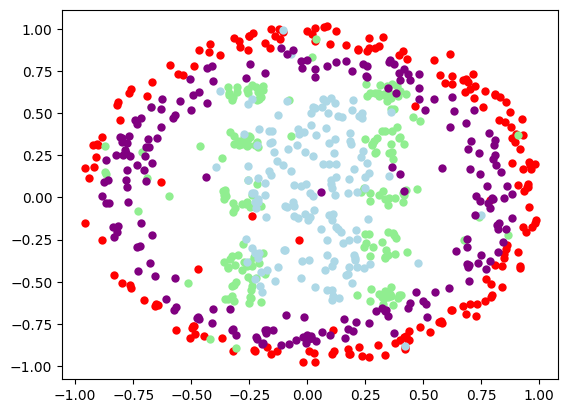

In [3]:
file = open('./train.csv', encoding='utf-8')
reader = csv.reader(file)
next(reader)
X_train = np.ndarray((0, 2))
y_train = np.ndarray((0,))
y_mapping = {'Bob': 0, 'Kate': 1, 'Mark': 2, 'Sue': 3}
i = 0
for row in reader:
    i += 1
    X_train = np.vstack((X, np.array(row[0:2])))
    y_train = np.append(y, y_mapping[row[2]])
X_train = X_train.astype(float)
y_train = y_train.astype(float)
file.close()

plt.scatter(X_train[y_train == 0, 0], X_train[y_train == 0, 1], label='Bob', c='red', linewidths=0)
plt.scatter(
    X_train[y_train == 1, 0], X_train[y_train == 1, 1], label='Kate', c='lightgreen', linewidths=0)
plt.scatter(
    X_train[y_train == 2, 0], X_train[y_train == 2, 1], label='Mark', c='lightblue', linewidths=0)
plt.scatter(X_train[y_train == 3, 0], X_train[y_train == 3, 1], label='Sue', c='purple', linewidths=0)

In [4]:
df_test = pd.read_csv('./test.csv')
X_test = df_test.drop(columns=['Competitor']).values
y_test = df_test['Competitor'].map(y_mapping).values

# Voting

In [19]:
cv = KFold(n_splits = 10, shuffle = True, random_state = 1)

pipe1 = Pipeline([['sc', StandardScaler()], ['clf', LogisticRegression(C = 10, random_state = 0, solver = "liblinear")]])
pipe2 = Pipeline([['clf', DecisionTreeClassifier(criterion = 'entropy', max_depth = 1, random_state = 0)]])
pipe3 = Pipeline([['clf', KNeighborsClassifier(n_neighbors = 1, p = 2, metric = 'minkowski')]])

gs1 = GridSearchCV(estimator = pipe1, param_grid = [{'clf__C': [0.01, 0.1, 1, 10, 100]}], scoring = 'accuracy', cv = cv, n_jobs = -1)
gs2 = GridSearchCV(estimator = pipe2, param_grid = [{'clf__max_depth': [1, 2, 3, 4, 5, 6, 7, None]}], scoring = 'accuracy', cv = cv, n_jobs = -1)
gs3 = GridSearchCV(estimator = pipe3, param_grid = [{'clf__n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}], scoring = 'accuracy', cv = cv, n_jobs = -1)

gs1.fit(X_train, y_train)
gs2.fit(X_train, y_train)
gs3.fit(X_train, y_train)

voting = VotingClassifier(estimators = [('lr', gs1.best_estimator_), ('dt', gs2.best_estimator_), ('knn', gs3.best_estimator_)], voting = 'soft')
param_grid = [{'lr__clf__C': [0.01, 0.1, 1, 10, 100], 'dt__clf__max_depth': [1, 2, 3, 4, 5, 6, 7, None], 'knn__clf__n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}]
gs = GridSearchCV(estimator = voting, param_grid = param_grid, scoring = 'accuracy', cv = cv, n_jobs = -1)
gs.fit(X_train, y_train)
print('accuracy-train = %.3f, accuracy-test = %.3f' %
      (gs.score(X_train, y_train), gs.score(X_test, y_test)))


accuracy-train = 0.934, accuracy-test = 0.795


# Bagging

In [ ]:
bagging = BaggingClassifier(base_estimator=gs2.best_estimator_, n_estimators=100, max_samples=0.5, max_features=0.5, bootstrap=True, bootstrap_features=False, n_jobs=-1, random_state=1)

param_grid = [{'base_estimator__clf__max_depth': [1, 2, 3, 4, 5, 6, 7, None], 'n_estimators': [10, 50, 100, 200, 300, 400, 500]}]

gs = GridSearchCV(estimator = bagging, param_grid = param_grid, scoring = 'accuracy', cv = cv, n_jobs = -1)

gs.fit(X_train, y_train)

print('accuracy-train = %.3f, accuracy-test = %.3f' %
      (gs.score(X_train, y_train), gs.score(X_test, y_test)))

In [9]:
print('accuracy-train = %.3f, accuracy-test = %.3f' %
      (gs.score(X_train, y_train), gs.score(X_test, y_test)))

accuracy-train = 0.779, accuracy-test = 0.714


# AdaBoost

- depth = 1

In [ ]:
tree = DecisionTreeClassifier(max_depth=1, random_state=1)
adaBoost = AdaBoostClassifier(base_estimator=tree, learning_rate=0.1, random_state=1)

param_grid = [{'base_estimator__max_depth': [1, 2, 3, 4, 5, 6, 7, None], 'n_estimators': [10, 50, 100, 200, 300, 400, 500], 'learning_rate': [0.01, 0.1, 1, 10, 100]}]
gs = GridSearchCV(estimator = adaBoost, param_grid = param_grid, scoring = 'accuracy', cv = cv, n_jobs = -1)
gs.fit(X_train, y_train)


In [25]:
print('accuracy-train = %.3f, accuracy-test = %.3f' %
      (gs.score(X_train, y_train), gs.score(X_test, y_test)))

accuracy-train = 0.687, accuracy-test = 0.578


- depth > 1

In [30]:
tree = DecisionTreeClassifier(random_state=1)
param_grid = [{'criterion':['gini','entropy'], 'max_depth': [1, 2, 3, 4, 5, 6, 7]}]
gs = GridSearchCV(estimator = tree, param_grid = param_grid, scoring = 'accuracy', cv = cv, n_jobs = -1)
gs.fit(X_train, y_train)

adaBoost = AdaBoostClassifier(base_estimator=gs.best_estimator_, random_state=0)
param_grid = [{'base_estimator__max_depth': [1, 2, 3, 4, 5, 6, 7, None], 'n_estimators': [10, 50, 100, 200, 300, 400, 500], 'learning_rate': [0.01, 0.1, 1, 10, 100]}]
gs = GridSearchCV(estimator = adaBoost, param_grid = param_grid, scoring = 'accuracy', cv = cv, n_jobs = -1)
gs.fit(X_train, y_train)


/home/mygodimatomato/miniconda3/envs/for_tf/lib/python3.8/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/mygodimatomato/miniconda3/envs/for_tf/lib/python3.8/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/mygodimatomato/miniconda3/envs/for_tf/lib/python3.8/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/mygodimatomato/miniconda3/envs/for_tf/lib/python3.8/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/mygodimatomato/miniconda3/envs/for_tf/lib/python3.8/site-packages/sklearn/ensemble/_base.py:156: FutureWar

GridSearchCV(cv=KFold(n_splits=10, random_state=1, shuffle=True),
             estimator=AdaBoostClassifier(base_estimator=DecisionTreeClassifier(criterion='entropy',
                                                                                max_depth=7,
                                                                                random_state=1),
                                          random_state=0),
             n_jobs=-1,
             param_grid=[{'base_estimator__max_depth': [1, 2, 3, 4, 5, 6, 7,
                                                        None],
                          'learning_rate': [0.01, 0.1, 1, 10, 100],
                          'n_estimators': [10, 50, 100, 200, 300, 400, 500]}],
             scoring='accuracy')

In [31]:
print('accuracy-train = %.3f, accuracy-test = %.3f' %
      (gs.score(X_train, y_train), gs.score(X_test, y_test)))

accuracy-train = 1.000, accuracy-test = 0.816


# Summary 

每個 model 都用了 grid search 去做了搜尋, 可以看到 voting 有著最好的 performance, 而 depth = 1 的 adaboost 的 performance 則是最差的, 也可以看到 adaboost 在 depth 不同的前提下可以有著很大的 performance 差異, 剩餘之中 performance 最好的則是 voting